In [214]:
from os import listdir
from os.path import isfile, join
import vaderSentiment
from collections import OrderedDict
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from matplotlib import pyplot
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
import re

import warnings
warnings.filterwarnings("ignore")

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from nltk.corpus import stopwords
import nltk

from gensim import corpora, models, similarities, matutils

# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer



In [ ]:
comment_files = [f for f in listdir('/home/ubuntu/newyorktimes_nlp/data/comments') if isfile(join('/home/ubuntu/newyorktimes_nlp/data/comments', f))]
article_files = [f for f in listdir('/home/ubuntu/newyorktimes_nlp/data/articles') if isfile(join('/home/ubuntu/newyorktimes_nlp/data/articles', f))]

In [ ]:
comment_df = pd.DataFrame(columns=['commentBody','newDesk','articleID'])
for file in comment_files:
    file = file.strip("'")
    df = pd.read_csv('/home/ubuntu/newyorktimes_nlp/data/comments/{}'.format(file),error_bad_lines=False, encoding = "ISO-8859-1")
    df = df[['commentBody','newDesk','articleID']]
    comment_df = comment_df.append(df)

In [ ]:
comment_df['commentBody'] = comment_df['commentBody'].astype(str)

In [ ]:
comment_df = comment_df[comment_df['newDesk'].isin(['Arts&Leisure','BookReview','Business','Climate','Culture','Dining','Foreign','Games','Learning','National','Podcasts','RealEstate','Science','Sports','Travel','Washington'])]

In [ ]:
comment_df.shape

In [132]:
comment_df = pd.read_pickle("./comments.pkl")

In [ ]:
def get_compound(x):
    try:
        return analyser.polarity_scores(x)['compound']
    except:
        return 0

In [ ]:
analyser = SentimentIntensityAnalyzer()
comment_df['compound'] = comment_df['commentBody'].apply(lambda x: get_compound(x))
with open('comments.pkl', 'wb') as output_file:
    pickle.dump(comment_df, output_file)

In [ ]:
articles = list(comment_df.articleID.unique())

In [ ]:
variance_df = pd.DataFrame(columns=['articleID','sentimentVariance'])

for article in articles: 
    sentiment = list(comment_df.loc[comment_df['articleID'] == article]['compound'])
    variance = np.var(sentiment)
    variance_df = variance_df.append({'articleID':article, 'sentimentVariance':variance},ignore_index=True)

In [ ]:
with open('sentiment.pkl', 'wb') as output_file:
    pickle.dump(variance_df, output_file)

In [ ]:
variance_df.head()

In [ ]:
variance_df.sentimentVariance.mean()

In [215]:
variance_df = pd.read_pickle("./sentiment.pkl")
variance_df = variance_df.dropna(axis=0)

## Plotting variance

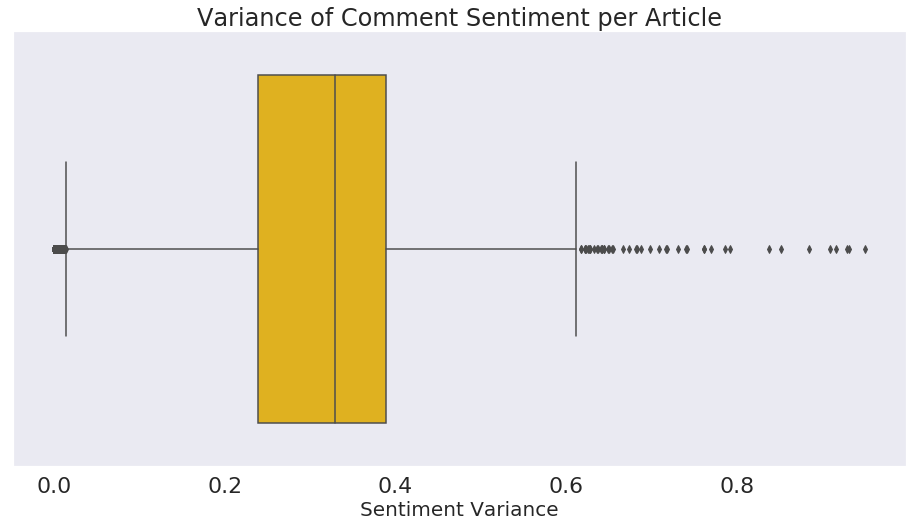

In [238]:
size = (16, 8)
fig, ax = pyplot.subplots(figsize=size)
sns.boxplot(x=variance_df.sentimentVariance,color='#FFC200').set_title('Variance of Comment Sentiment per Article')
ax.set_xlabel('Sentiment Variance',fontsize=20)
sns.set(font_scale = 2)
sns.set_style("dark")
ax.grid(False)


In [239]:
fig.savefig("variance.png")

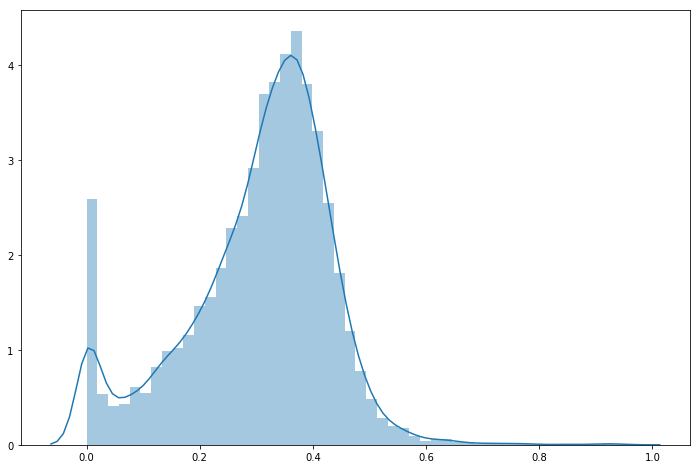

In [6]:
size = (12, 8)
fig, ax = pyplot.subplots(figsize=size)
x=list(variance_df.sentimentVariance)
sns.distplot(x)

## Selecting controversial articles

In [48]:
q1, q2, q3= np.percentile(list(variance_df.sentimentVariance),[25,50,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q2 +(1.5 * iqr) 
print(lower_bound)
print(upper_bound)                      

0.014448804319950909
0.5534387918441649


In [49]:
right_outliers =variance_df[variance_df['sentimentVariance'] >  upper_bound]
right_outliers[:5]

,articleID,sentimentVariance
153,5aafa21247de81a901212761,0.650417
190,5ab0b17447de81a901213053,0.596350
444,5ab8a88447de81a90121725f,0.682854
467,5ab90e4d47de81a901217568,0.649158
497,5ab9fa0547de81a901217bf5,0.557229


In [50]:
len(right_outliers)

95

In [51]:
with open('controversial.pkl', 'wb') as output_file:
    pickle.dump(right_outliers, output_file)

In [58]:
articles = pd.read_pickle("./articles.pkl")

In [82]:
def remove_numbers(text):
    return ''.join([i for i in text if not i.isdigit()])

In [91]:
remove_numbers('12Thi234s func23470t3ion wo3519r1309k143s')

'This function works'

In [104]:
articles['articleText'] = articles['articleText'].apply(lambda x: re.sub('[0-9]+', '', x))

In [105]:
contro_articles = right_outliers.articleID
contro_text = [articles.loc[articles['articleID'] == x].articleText for x in contro_articles]

## LDA

In [211]:
words = nltk.corpus.stopwords.words('english')
add = ['articletext','dtype','series','sh','object','articletext dtype','dtype object','subscribe','article','nan','name','image','could','story']
for word in add:
    words.append(word)
docs = contro_text
docs = [str(i) for i in docs]
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words=words, token_pattern="\\b[a-z][a-z]+\\b")
count_vectorizer.fit(docs)
doc_word = count_vectorizer.transform(docs).transpose()
corpus = matutils.Sparse2Corpus(doc_word)
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=10)
lda.print_topics()

2019-03-01 01:39:20,068 : INFO : using symmetric alpha at 0.3333333333333333
2019-03-01 01:39:20,070 : INFO : using symmetric eta at 0.3333333333333333
2019-03-01 01:39:20,074 : INFO : using serial LDA version on this node
2019-03-01 01:39:20,085 : INFO : running online (multi-pass) LDA training, 3 topics, 10 passes over the supplied corpus of 95 documents, updating model once every 95 documents, evaluating perplexity every 95 documents, iterating 50x with a convergence threshold of 0.001000
2019-03-01 01:39:20,358 : INFO : -10.939 per-word bound, 1963.6 perplexity estimate based on a held-out corpus of 95 documents with 28093 words
2019-03-01 01:39:20,359 : INFO : PROGRESS: pass 0, at document #95/95
2019-03-01 01:39:20,438 : INFO : topic #0 (0.333): 0.003*"said" + 0.003*"one" + 0.002*"new" + 0.002*"would" + 0.002*"people" + 0.002*"like" + 0.002*"united" + 0.002*"times" + 0.002*"time" + 0.002*"also"
2019-03-01 01:39:20,439 : INFO : topic #1 (0.333): 0.004*"said" + 0.002*"one" + 0.002*

2019-03-01 01:39:22,719 : INFO : topic #2 (0.333): 0.003*"think" + 0.002*"us" + 0.002*"read" + 0.002*"new" + 0.002*"work" + 0.002*"like" + 0.002*"comment" + 0.002*"many" + 0.002*"listen" + 0.002*"would"
2019-03-01 01:39:22,720 : INFO : topic diff=0.015164, rho=0.316228
2019-03-01 01:39:22,956 : INFO : -9.582 per-word bound, 766.2 perplexity estimate based on a held-out corpus of 95 documents with 28093 words
2019-03-01 01:39:22,957 : INFO : PROGRESS: pass 9, at document #95/95
2019-03-01 01:39:22,995 : INFO : topic #0 (0.333): 0.004*"said" + 0.003*"one" + 0.003*"people" + 0.002*"new" + 0.002*"would" + 0.002*"like" + 0.002*"united" + 0.002*"times" + 0.002*"also" + 0.002*"refugee"
2019-03-01 01:39:22,996 : INFO : topic #1 (0.333): 0.004*"said" + 0.002*"president" + 0.002*"one" + 0.002*"would" + 0.002*"first" + 0.002*"year" + 0.002*"united" + 0.002*"trump" + 0.002*"new" + 0.001*"people"
2019-03-01 01:39:22,997 : INFO : topic #2 (0.333): 0.003*"think" + 0.002*"us" + 0.002*"read" + 0.002*"n

[(0,
  '0.004*"said" + 0.003*"one" + 0.003*"people" + 0.002*"new" + 0.002*"would" + 0.002*"like" + 0.002*"united" + 0.002*"times" + 0.002*"also" + 0.002*"refugee"'),
 (1,
  '0.004*"said" + 0.002*"president" + 0.002*"one" + 0.002*"would" + 0.002*"first" + 0.002*"year" + 0.002*"united" + 0.002*"trump" + 0.002*"new" + 0.001*"people"'),
 (2,
  '0.003*"think" + 0.002*"us" + 0.002*"read" + 0.002*"new" + 0.002*"work" + 0.002*"comment" + 0.002*"like" + 0.002*"many" + 0.002*"listen" + 0.002*"would"')]

## NMF

In [212]:
vectorizer = CountVectorizer(stop_words = words)
doc_word = vectorizer.fit_transform(docs)
nmf_model = NMF(3)
doc_topic = nmf_model.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ['topic1','topic2','topic3'],
             columns = vectorizer.get_feature_names())

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
said, one, would, people, also, like, new, many, black, civil

Topic  1
refugee, crisis, united, war, world, history, today, help, people, time

Topic  2
year, president, trump, first, office, think, new, policy, times, york


## LSA

In [213]:
lsa = TruncatedSVD(3)
doc_topic = lsa.fit_transform(doc_word)
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ['topic1','topic2','topic3'],
             columns = vectorizer.get_feature_names())
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
said, people, refugee, crisis, united, history, one, world, would, new

Topic  1
crisis, refugee, war, world, united, today, help, history, sharps, text

Topic  2
year, president, trump, first, office, think, policy, presidency, analysis, new


In [125]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

In [126]:
hasNumbers(articles.articleText)

False

In [195]:
example = right_outliers.sample(15)['articleID']
example

2253    5a6a291010f40f00018bdbad
7482    5908336e7c459f24986dd318
6583    58b91b7e7c459f2525d1f965
6204    5a95a91510f40f00018c356b
4553    5896362e95d0e0392607ea75
4049    5ad799aa068401528a2a96ca
7523    590995197c459f24986dd691
7958    591c11207c459f24986e007a
1681    58802bc595d0e0392607b843
5556    5a79df1610f40f00018bfb1e
2318    5a686fa410f40f00018bd736
5466    5a7510a710f40f00018bf4cc
2098    5a7075f610f40f00018be7a1
190     5ab0b17447de81a901213053
6469    5a8d746110f40f00018c22e0
Name: articleID, dtype: object

In [196]:
example_comments = [comment_df.loc[comment_df['articleID'] == '5a6a291010f40f00018bdbad'].commentBody]
pd.set_option('display.max_colwidth', -1)
example_comments

[67253    For President Donald Trump first year in office we are giving him a D. We chose this grade for a variety of reasons, According to "They were bad he may be worse." by Micheal Gonchar, President Trump was the first president who failed to defend the nation from an attack on our democracy by a hostile foreign power, and to resist the investigation of that attack, he also threaten his defeated political opponent with imprisonment, and denigrated friendly countries and allies as well as a whole continent with racist vulgarities. Despite the bad, President trump has did something good he nominated many-well qualified conservative jurists to the appeals courts; but the quality of his district- court nominees appears to be significantly lower, so even though he's getting people hired they aren't qualified for the job. For all those reasons listed we give President Donald Trump a D.                                                                                                        

In [174]:
example_comments = [comment_df.loc[comment_df['articleID'] == '5acdc173068401528a2a6eba'].commentBody]
pd.set_option('display.max_colwidth', -1)
example_comments

[74491    I am the person who will cry at the death of a dog in a movie while the death of a person in said movie leaves me unfazed. I think the reason why I find myself more sympathetic towards the welfare of animals is because in my eyes they have no voice and this innocence about them. But in no way does that mean that Iâd be able to choose the welfare of an animal over the welfare of a human. There is no authority that gives us the right to make the decision that our lives are more valuable than that of a dog, gorilla, cow, lion, etc. so there should be no reason why we should treat them as anything less than ourselves. And on that note there is no reason why we should only uphold the lives of certain animals when without all the creatures of the world there would be no ecosystem to support our society.<br/>Instead of focusing on just animal welfare or just human welfare we should focus on helping both since their welfareâs are dependent on each other in most areas of the world

In [198]:
articles.loc[articles['articleID'] == '5acdc173068401528a2a6eba'].webURL

3918    https://www.nytimes.com/2018/04/11/learning/is-it-wrong-to-focus-on-animal-welfare-when-humans-are-suffering.html
Name: webURL, dtype: object

In [202]:
analyser = SentimentIntensityAnalyzer()
print(analyser.polarity_scores("The idea that animals are pure and innocent beings is plainly a myth.")['compound'])
print(analyser.polarity_scores("Personally I care more for animals than humans.")['compound'])
print(analyser.polarity_scores("I think the issue is that nowadays in our world, death is everywhere. It's become a normal routine to see people dying on the news")['compound'])

0.34
0.4939
-0.5994


In [210]:
np.var([0.24,0.939,-0.9994])

0.6424564355555555